In [1]:
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from threeML import *
from threeML.io.package_data import get_path_of_data_file

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


# Constructing plugins from TimeSeries

Many times we encounter event lists or sets of spectral histograms from which we would like to derive a single or set of plugins. For this purpose, we provide the **TimeSeriesBuilder** which provides a unified interface to time series data. Here we will demonstrate how to construct plugins from an different of data types.

## Constructing time series objects from different data types

The **TimeSeriesBuilder** currently supports reading of the following data type:
* A generic PHAII data file
* GBM TTE/CSPEC/CTIME files
* LAT LLE files

If you would like to build a time series from your own custom data, consider creating a TimeSeriesBuilder.from_your_data() class method.

### GBM Data 

Building plugins from GBM is achieved in the following fashion

In [2]:

cspec_file = get_path_of_data_file('datasets/glg_cspec_n3_bn080916009_v01.pha')
tte_file = get_path_of_data_file('datasets/glg_tte_n3_bn080916009_v01.fit.gz')
gbm_rsp = get_path_of_data_file('datasets/glg_cspec_n3_bn080916009_v00.rsp2')


gbm_cspec = TimeSeriesBuilder.from_gbm_cspec_or_ctime('nai3_cspec',
                                                      cspec_or_ctime_file=cspec_file,
                                                      rsp_file=gbm_rsp)

gbm_tte = TimeSeriesBuilder.from_gbm_tte('nai3_tte',
                                          tte_file=tte_file,
                                          rsp_file=gbm_rsp)


WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


WARNING UserWarning: No TLMIN keyword found. This DRM does not follow OGIP standards. Assuming TLMIN=1


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)




WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)



### LAT LLE data

LAT LLE data is constructed in a similar fashion

In [3]:
lle_file = get_path_of_data_file('datasets/gll_lle_bn080916009_v10.fit')
ft2_file = get_path_of_data_file('datasets/gll_pt_bn080916009_v10.fit')
lle_rsp = get_path_of_data_file('datasets/gll_cspec_bn080916009_v10.rsp')

lat_lle = TimeSeriesBuilder.from_lat_lle('lat_lle',
                                        lle_file=lle_file,
                                        ft2_file=ft2_file,
                                        rsp_file=lle_rsp)




## Viewing Lightcurves and selecting source intervals

All time series objects share the same commands to get you to a plugin. 
Let's have a look at the GBM TTE lightcurve.

<IPython.core.display.Javascript object>


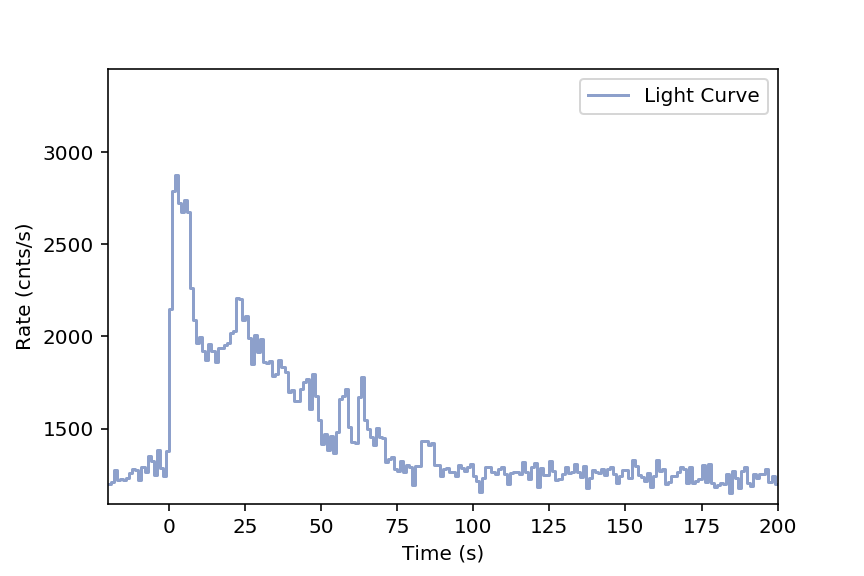

In [7]:
gbm_tte.view_lightcurve(start=-20,stop=200)

Perhaps we want to fit the time interval from 0-10 seconds. We make a selection like this:


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)



<IPython.core.display.Javascript object>


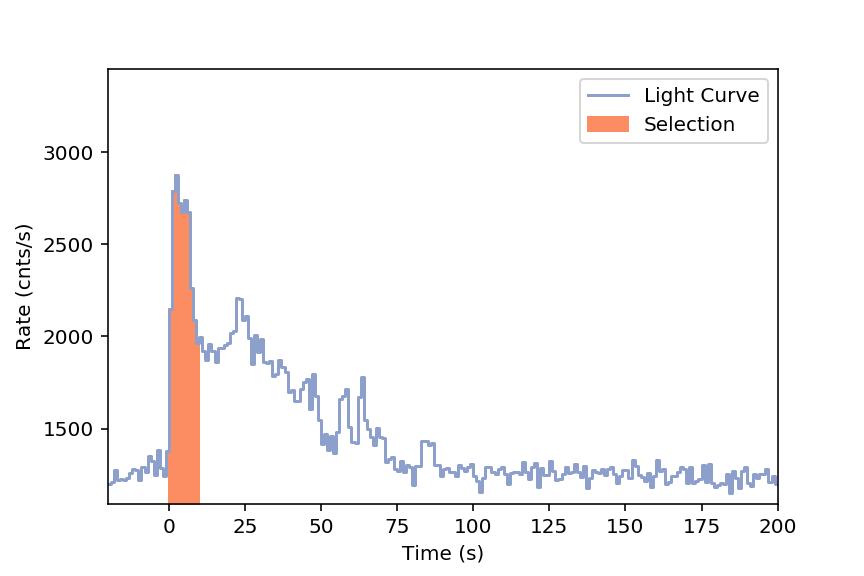

In [9]:
gbm_tte.set_active_time_interval('0-10')
gbm_tte.view_lightcurve(start=-20,stop=200)

For event list style data like time tagged events, the selection is *exact*. However, pre-binned data in the form of e.g. PHAII files will have the selection automatically adjusted to the underlying temporal bins.

Several discontinuous time selections can be made.

## Fitting a polynomial background

In order to get to a plugin, we need to model and create an estimated the background for our interval of interest. The process that we have implemented is to fit temporal off-source regions to polynomials in time. First, a polynomial is fit to the total count rate. From this fit we determine the best polynomial order via a likelihood ratio test, unless the user supplies a polynomial order in the constructor or directly via the polynomial_order attribute. Then, this order of polynomial is fit to every channel in the data.

From the polynomial fit, the polynomial is integrated in time over the active source interval to estimate the count rate in each channel. The estimated background and background errors then stored for each channel.


Auto-determined polynomial order: 0




Unbinned 0-order polynomial fit with the Nelder-Mead method




<IPython.core.display.Javascript object>


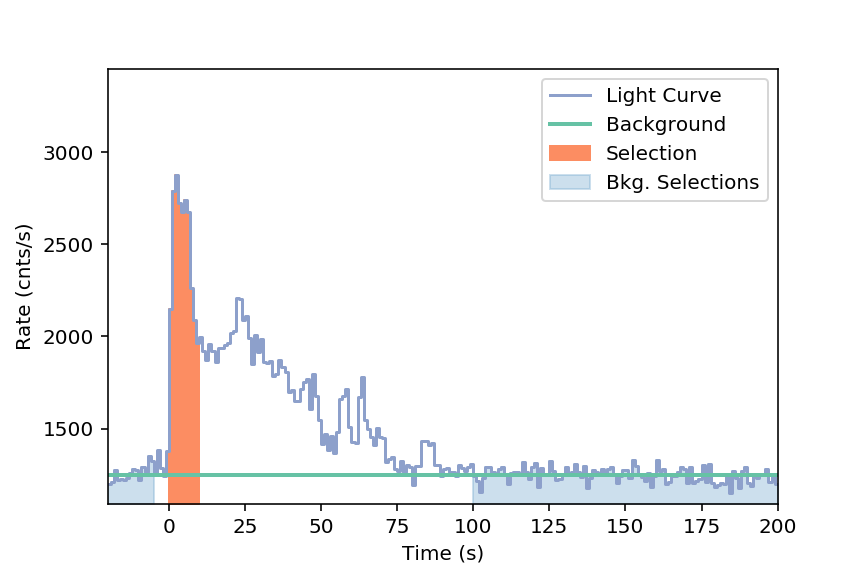

In [13]:
gbm_tte.set_background_interval('-24--5','100-200')
gbm_tte.view_lightcurve(start=-20,stop=200)

For event list data, binned or unbinned background fits are possible. For pre-binned data, only a binned fit is possible. 

In [19]:
gbm_tte.set_background_interval('-24--5','100-200',unbinned=False)


Auto-determined polynomial order: 0




Binned 0-order polynomial fit with the Powell method




## Creating a plugin

With our background selections made, we can now create a plugin instance. In the case of GBM data, this results in a **DispersionSpectrumLike**
plugin. Please refer to the Plugins documentation for more details.

In [21]:
gbm_plugin = gbm_tte.to_spectrumlike()

Auto-probed noise models:
- observation: poisson
- background: gaussian


In [22]:
gbm_plugin.display()

,0
n. channels,128
total rate,2503.99
total bkg. rate,1256.88
total bkg. rate error,3.25941
exposure,9.95012
bkg. exposure,9.95012
significance,92.9247
is poisson,True
bkg. is poisson,False
response,None


## Binning event data

We can bin event lists via a variety of methods:

* Bayesian blocks (Scargle et al. 2013)
* significance
* constant cadence
* custom binning


#### Bayesian blocks
Specify a start and stop time as well as a chance probablity. Optionally, one can use the background to create blocks with knowledge of the shape of the background.

<IPython.core.display.Javascript object>


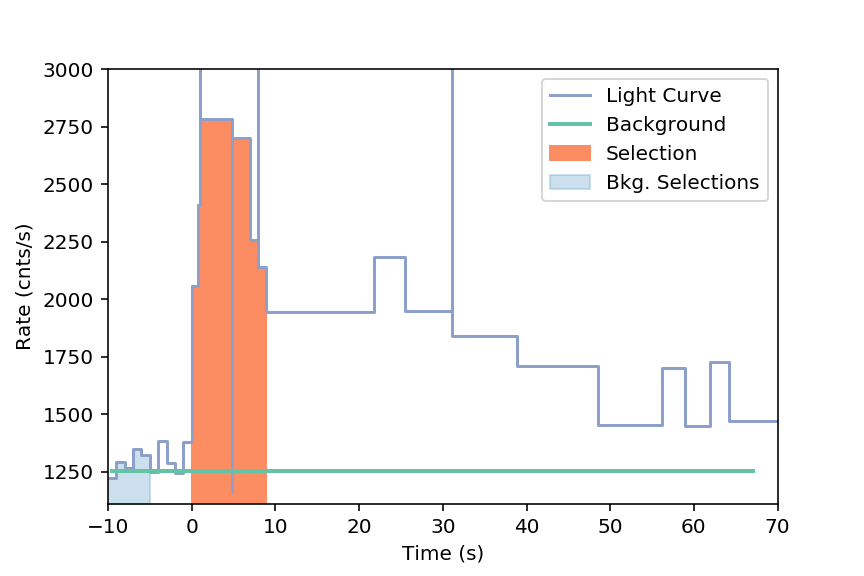

<IPython.core.display.Javascript object>


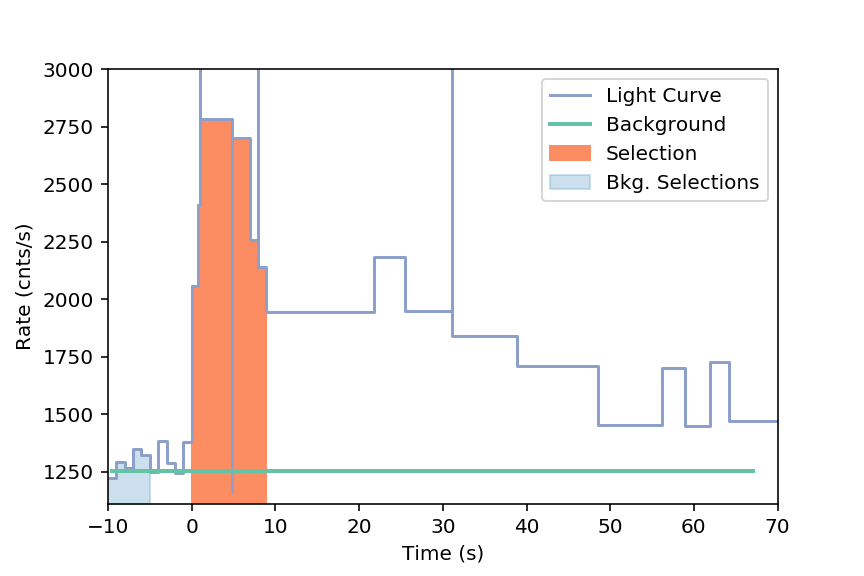

In [29]:
gbm_tte.create_time_bins(start=0, stop=70, method='bayesblocks', p0=.1)
gbm_tte.view_lightcurve(use_binner=True)
_=plt.ylim(top=3000)

gbm_tte.create_time_bins(start=0, stop=70, method='bayesblocks', use_background=True, p0=.1)
gbm_tte.view_lightcurve(use_binner=True)
_=plt.ylim(top=3000)

#### Binning by significance
To bin by significance over background, specify a start and stop time as well as the significance to achieve in sigma.

<IPython.core.display.Javascript object>


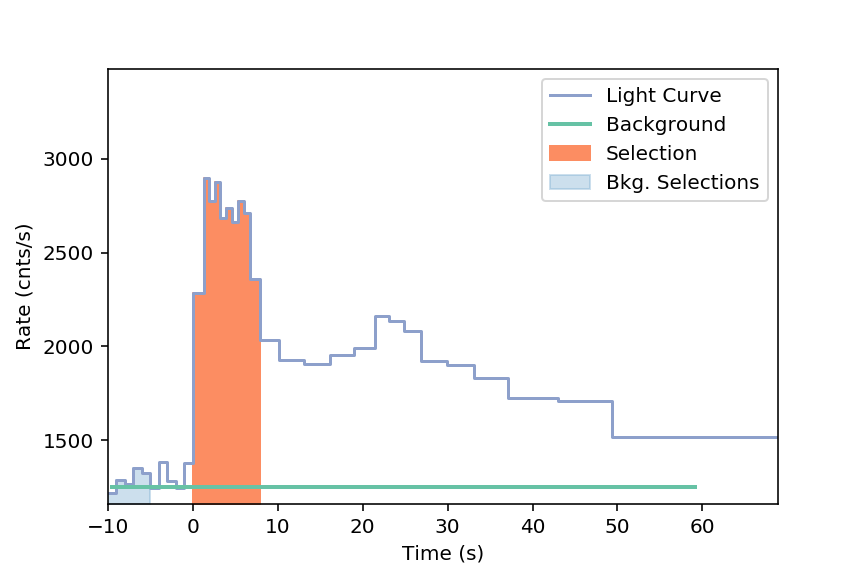

In [31]:
gbm_tte.create_time_bins(start=0, stop=70, method='significance', sigma=30)
gbm_tte.view_lightcurve(use_binner=True)

#### Constant cadence
Bin by a constant time delta


<IPython.core.display.Javascript object>


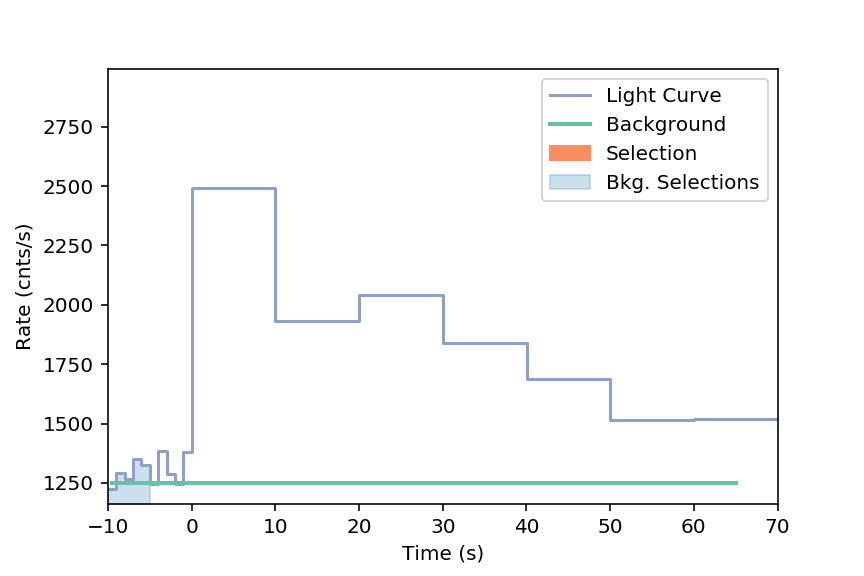

In [32]:
gbm_tte.create_time_bins(start=0, stop=70, method='constant', dt=10)
gbm_tte.view_lightcurve(use_binner=True)

#### Custom bins

For custom bins, supply a list of start and stop times

<IPython.core.display.Javascript object>


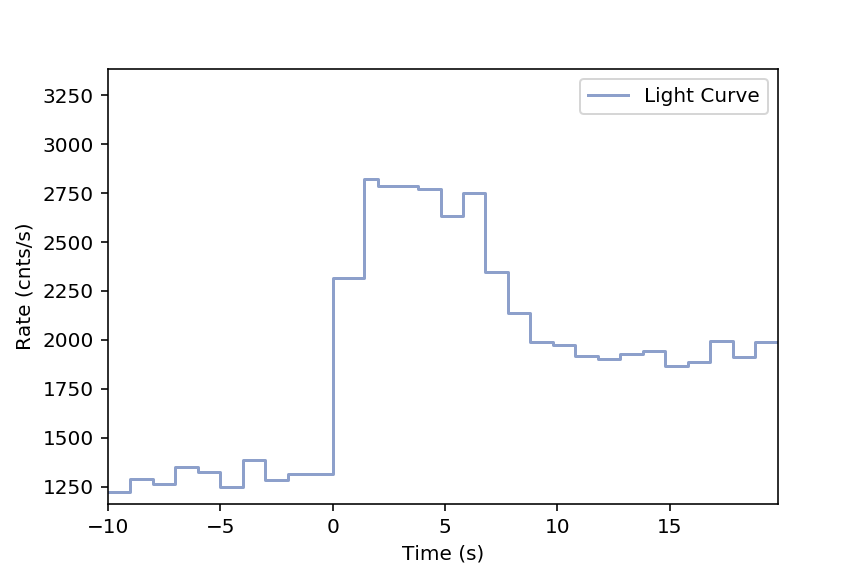

In [4]:
gbm_tte.create_time_bins(start=[0,1.4,2], stop=[1.4,2,3.8], method='custom')
gbm_tte.view_lightcurve(use_binner=True)

### Creating PHAII files and a series of plugins
From the binned time series, we can create a series of plugins to fit or export the selections to PHAII files.


In [39]:
gbm_plugins = gbm_tte.to_spectrumlike(from_bins=True)

gbm_tte.write_pha_from_binner('my_selections',overwrite=True)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)



We can also export list from pre-binned data, but it is important to specifiy the time range we wish to use.

Auto-determined polynomial order: 1




Binned 1-order polynomial fit with the Powell method




<IPython.core.display.Javascript object>


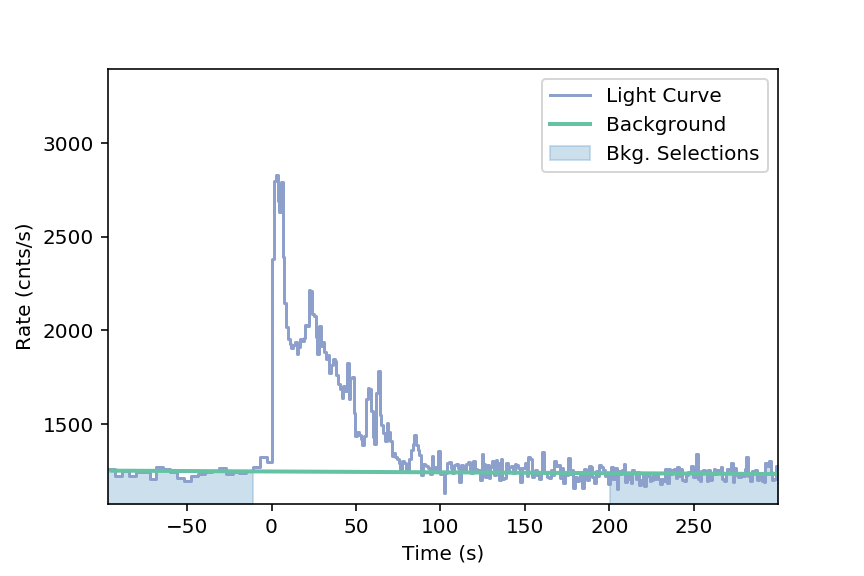


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than 

In [4]:
gbm_cspec.set_background_interval('-200--10','200-400')
gbm_cspec.view_lightcurve(start=-100,stop=300)
gbm_plugins = gbm_cspec.to_spectrumlike(from_bins=True, start=1,stop=10)

## Saving and restoring backgrounds

When dealing with many observations, refitting backgrounds can be time consuming. Therefore, 3ML allows you to save the polynomials to HDF5 files which can be reloaded quickly.

In [5]:
gbm_cspec.save_background('my_cspec_background')


Saved fitted background to my_cspec_background.h5.




WARNING PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]




This even allows us to read the background of the CSPEC data (with a much longer time baseline) in to the TTE file.

In [7]:
gbm_tte = TimeSeriesBuilder.from_gbm_tte('nai3_tte',
                                          tte_file=tte_file,
                                          rsp_file=gbm_rsp,
                                          restore_background='my_cspec_background.h5')

Successfully restored fit from my_cspec_background.h5



WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)


WARNING RuntimeWarning: Minimum MC energy (5.0) is larger than minimum EBOUNDS energy (4.26700019836)



<IPython.core.display.Javascript object>


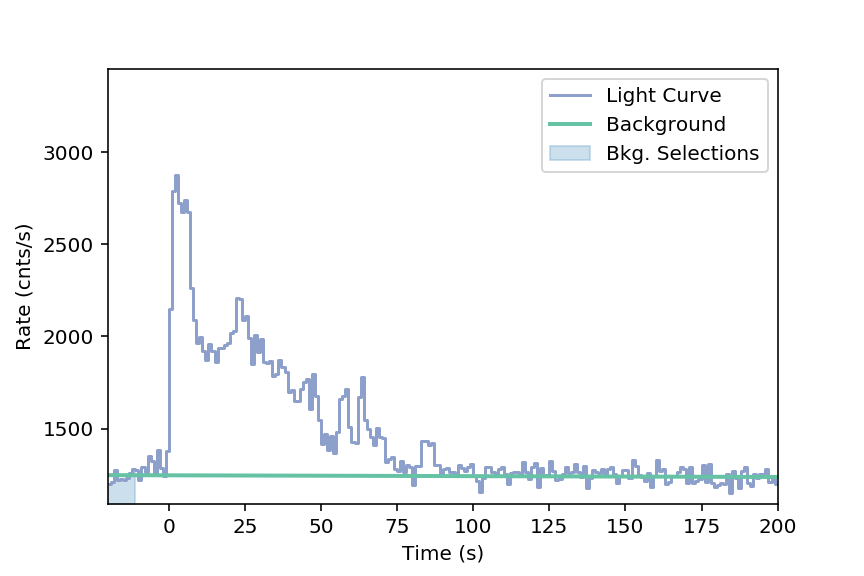

In [9]:
gbm_tte.view_lightcurve(start=-20,stop=200)